# Notebook to analyze some Programming Language Info

Here some facts about the programming languages used by Stack Overflow users 2015 will be extracted:
## First import all necessary libraries:
        

In [1]:
# a look at the data
import sys as ys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as m
from collections import defaultdict
import seaborn as sns
%matplotlib inline


In [2]:

df = pd.read_csv('survey_results_public.csv')
#shorter extract of data for debug purposes
#df = pd.read_csv('c.csv')
schema = pd.read_csv('survey_results_schema.csv')

df.head(3)


,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN


## Subroutine Collection

### Subroutine to measure the difference between set and wish of prog. lang. 

here a 34 dim space is introduced, each base vector is representing a programming language.
Thus, C e.g. is [1,0,0,0......0], c++ is [0,1,0,0,0,....].
Each 3 or 4 languages mentioned in the HaveWorkedLanguage or WantWork-Language column represent a special vector in this space. The entries for these languages are 1, all other are zero.

The dot product describes the projection of such an hypervector on another of these, and is a crude measure of 
'difference' between these statements. 

0 means no single fit between languages used and languages keen to be used,
1 means complete fit between languages used and languages keen to be used,

The subroutine below takes care of transfering the statements to this simple metric.

In [3]:

mapper = {
    "JavaScript":  0,     "Python":  1,     "SQL":  2,     "C#":  3,     "Java":  4,     "C++":  5,     "TypeScript":  6,     "Go":  7, 
    "PHP":  8,     "Swift":  9,     "C":  10,     "Ruby":  11,     "Scala":  12,     "Rust":  13,     "R":  14,     "F#":  15, 
    "Haskell":  16,     "Objective-C": 17,    "Elixir":  18,     "Assembly":  19,     "Clojure":  20,     "Erlang":  21,     "Perl":  22,     "CoffeeScript":     23, 
    "Lua":  24,     "Groovy":  25,     "Matlab":  26,     "VB.NET":  27,     "Common Lisp":      28,    "Julia":  29,     "Dart":  30,     "Smalltalk":  31, 
    "VBA":  32,     "Hack":  33,     "Visual Basic 6":  34
}

def createVectorFromList(mapobj, entry1, entry2):
    '''
    INPUT:
    mapobj - dictionary of list position of programming language name
    entry1 - ; separated list of prog.-lang.-names
    entry2 - ; separated list of prog.-lang.-names
    OUTPUT:
    float value 0..1 characterising the geometrical similarity of the language lists in a 34 dim space.
    This value is independent of sequence
    '''
    r1 = list(0 for _ in range(len(mapobj)))
    r2 = list(0 for _ in range(len(mapobj)))
    l1 = str.split(entry1,sep='; ')
    l2 = str.split(entry2,sep='; ')
    for k in l1:
        r1[mapobj[k]] = 1
    for k in l2:
        r2[mapobj[k]] = 1
    
    m_a = m.sqrt(pd.Series(r1).dot(pd.Series(r1))) 
    m_b = m.sqrt(pd.Series(r2).dot(pd.Series(r2))) 
    metric = pd.Series(r1).dot(pd.Series(r2))/m_a/m_b
    return metric


Short Test: 1 0 1/sqrt(2)

In [4]:
u = createVectorFromList(mapper,'Python; C; C#','Python; C; C#')
print(u)
u = createVectorFromList(mapper,'Python; C; C#','Matlab; Haskell')
print(u)
u = createVectorFromList(mapper,'Python; C; C#; Go','Python; C')
print(u)

1.0000000000000002
0.0
0.7071067811865475


### 2 small helpers to drop NaN and calculate measure between 2 cols

In [5]:

def cleansData(df):
    '''
    INPUT:
    df - dataframe containing NaN in either one of 3 columns
    OUTPUT:
    dataframe that has all NaN containing rows dropped
    '''
    print("-----------------------")
    df = df.dropna(axis=0, subset=['HaveWorkedLanguage','WantWorkLanguage','JobSatisfaction'])
    df.reset_index(drop=True, inplace=True)
    return df

def calcWeight(df):
    '''
    INPUT:
    df - dataframe two master rows with semikolon-space separated language lists 
    OUTPUT:
    df - dataframe with new column containing the dot product of the two 34 dimensional language vectors
    This column is a crude metric of overlap of used and wished to use languages
    '''
    for index, row in df.iterrows():
        u = createVectorFromList(mapper, row['HaveWorkedLanguage'], row['WantWorkLanguage'])
        df.loc[index, 'Weight']= u
    return df


### One-Column-Exploder

This subroutine will explode the ; separated entries into a row for each substring, keeping the other records unharmed.
After using this, One can create a value-count frequency analysis of the different languages. 

In [6]:
def createDFwithExplodedLanguage(adf,col):
    '''
    INPUT:
    df - dataframe 
    col - name of column with categorical string list to explode e.g. 'C; C#; Haskell'
    OUTPUT:
    df - with e.g. 2 new rows where the list is exploded, all other columns unharmed.
    e.g. ...C
         ...C#
         ...Haskell
    name of column stays the same 
    '''
    df = adf.copy()
    s = df[col].str.split('; ').apply(pd.Series, 1).stack()
    s.index = s.index.droplevel(-1) # to line up with xdf's index
    s.name = col # needs a name to join
    del df[col]
    return df.join(s)



## Reduce the dataset to the only used columns for the analysis to come

In [37]:
#=========================================================================================================
#=========================================================================================================
#=========================================================================================================
#=========================================================================================================

print("here i slice it")

xdf = df.loc[:,('Respondent','HaveWorkedLanguage','WantWorkLanguage','JobSatisfaction', 'Professional')]


print ('Size of dataset before NaN cleansing', xdf.shape[0])
xdf = cleansData(xdf)
print ('Size of dataset after NaN cleansing', xdf.shape[0])
xdf = calcWeight(xdf)

#now check new Weight - Metrics Vector
print( xdf.head())



here i slice it
Size of dataset before NaN cleansing 19102
-----------------------
Size of dataset after NaN cleansing 10476
   Respondent                                 HaveWorkedLanguage  \
0           3                                  Java; PHP; Python   
1           4                             Matlab; Python; R; SQL   
2           7                                     Matlab; Python   
3           8  CoffeeScript; Clojure; Elixir; Erlang; Haskell...   
4           9                                     C#; JavaScript   

                            WantWorkLanguage  JobSatisfaction  \
0                            C; Python; Rust              9.0   
1                     Matlab; Python; R; SQL              3.0   
2  JavaScript; Julia; Matlab; Python; R; SQL              6.0   
3            Clojure; Elixir; Haskell; Scala              7.0   
4                                     F#; Go              6.0   

                                        Professional    Weight  
0         

### Now the simple statistics for usage of languages

In [8]:
def createDFwithExplodedLanguage(adf,col):
    df = adf.copy()
    s = df[col].str.split('; ').apply(pd.Series, 1).stack()
    s.index = s.index.droplevel(-1) # to line up with xdf's index
    s.name = col # needs a name to join
    del df[col]
    return df.join(s)



In [38]:
rds = createDFwithExplodedLanguage(xdf,'HaveWorkedLanguage')
languageSet=rds.groupby(['HaveWorkedLanguage']).mean()['JobSatisfaction']
print("----RDS----")
print(rds.head(2))
print("----XDF----")
print(xdf.head(2))
print("===========================================================")
print ('change of size {} non exploded to {} exploded', xdf.shape[0], rds.shape[0])
sds = createDFwithExplodedLanguage(xdf,'WantWorkLanguage')
languageWish=sds.groupby(['WantWorkLanguage']).mean()['JobSatisfaction']
print("----SDS----")
print(sds.head(2))
print("----XDF----")
print(xdf.head(2))
print("===========================================================")
print ('change of size {} non exploded to {} exploded', xdf.shape[0], sds.shape[0])


----RDS----
   Respondent WantWorkLanguage  JobSatisfaction            Professional  \
0           3  C; Python; Rust              9.0  Professional developer   
0           3  C; Python; Rust              9.0  Professional developer   

     Weight HaveWorkedLanguage  
0  0.333333               Java  
0  0.333333                PHP  
----XDF----
   Respondent      HaveWorkedLanguage        WantWorkLanguage  \
0           3       Java; PHP; Python         C; Python; Rust   
1           4  Matlab; Python; R; SQL  Matlab; Python; R; SQL   

   JobSatisfaction                                       Professional  \
0              9.0                             Professional developer   
1              3.0  Professional non-developer who sometimes write...   

     Weight  
0  0.333333  
1  1.000000  
change of size {} non exploded to {} exploded 10476 37905
----SDS----
   Respondent HaveWorkedLanguage  JobSatisfaction            Professional  \
0           3  Java; PHP; Python              

In [39]:

print( xdf.head())

   Respondent                                 HaveWorkedLanguage  \
0           3                                  Java; PHP; Python   
1           4                             Matlab; Python; R; SQL   
2           7                                     Matlab; Python   
3           8  CoffeeScript; Clojure; Elixir; Erlang; Haskell...   
4           9                                     C#; JavaScript   

                            WantWorkLanguage  JobSatisfaction  \
0                            C; Python; Rust              9.0   
1                     Matlab; Python; R; SQL              3.0   
2  JavaScript; Julia; Matlab; Python; R; SQL              6.0   
3            Clojure; Elixir; Haskell; Scala              7.0   
4                                     F#; Go              6.0   

                                        Professional    Weight  
0                             Professional developer  0.333333  
1  Professional non-developer who sometimes write...  1.000000  
2  Pr

## Fun Fact: Language vs. Job Satisfaction :-)

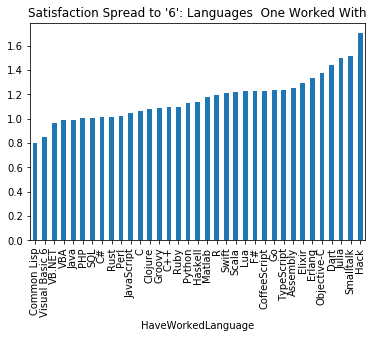

In [59]:
#==========================
# Fun fact evaluation: correlation between JobSatisfaction and Programming Language
# don't mix correlation and causality, as there are 150 more input variables!
#==========================
(languageSet.sort_values()-6).plot(kind="bar");
plt.title("Satisfaction Spread to '6': Languages  One Worked With");
#plt.savefig("kindoflanguages.png")
plt.savefig("kindoflanguages.pdf")


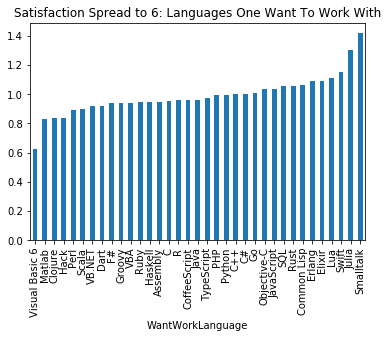

In [42]:
#==========================
# Fun fact evaluation: correlation between JobSatisfaction and 'keen on' Programming Language
# don't mix correlation and causality, as there are 150 more input variables! (not used further)
#==========================
(languageWish.sort_values()-6).plot(kind="bar");
plt.title("Satisfaction Spread to 6: Languages One Want To Work With");
plt.savefig("kindoflanguageswish.png")


## Descriptive Statistics

###  Correlation Analysis of built crude Metric of Discrepancy and Job Satisfaction

   Respondent      HaveWorkedLanguage        WantWorkLanguage  \
0           3       Java; PHP; Python         C; Python; Rust   
1           4  Matlab; Python; R; SQL  Matlab; Python; R; SQL   

   JobSatisfaction                                       Professional  \
0              9.0                             Professional developer   
1              3.0  Professional non-developer who sometimes write...   

     Weight  
0  0.333333  
1  1.000000  


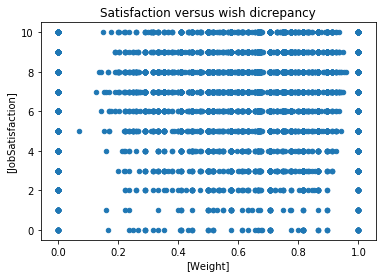

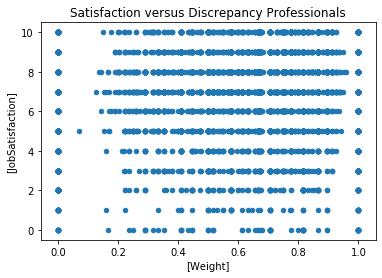

In [16]:
#==========================
# Correlation Analysis of built metric of discrepancy and Job Satisfaction
#==========================
print(xdf.head(2))
xdf.plot.scatter(x=['Weight'], y=['JobSatisfaction'])
plt.title("Satisfaction versus wish dicrepancy");
plt.savefig("kindoflanguagediscrepancy.png")

proxdf = xdf[xdf.Professional == 'Professional developer']
proxdf.plot.scatter(x=['Weight'], y=['JobSatisfaction'])
plt.title("Satisfaction versus Discrepancy Professionals");
plt.savefig("kindoflanguagediscrepancypro.png")


### Preference of Programming Languages as used nowadays

lay ----
 Assembly        1.390677
C               5.768736
C#              5.949008
C++             5.408190
Clojure         0.257533
CoffeeScript    0.489312
Common Lisp     0.360546
Dart            0.051507
Elixir          0.180273
Erlang          0.103013
Name: HaveWorkedLanguage, dtype: float64 ----
 Assembly        0.936552
C               4.149848
C#              9.777074
C++             5.046828
Clojure         0.311305
CoffeeScript    0.947105
Common Lisp     0.160929
Dart            0.089698
Elixir          0.306028
Erlang          0.182034
Name: HaveWorkedLanguage, dtype: float64 pro ----
 Assembly         0.884722
C                3.965081
C#              10.213979
C++              5.005585
Clojure          0.317442
CoffeeScript     0.999353
Common Lisp      0.138146
Dart             0.094057
Elixir           0.320381
Erlang           0.191053
Name: HaveWorkedLanguage, dtype: float64


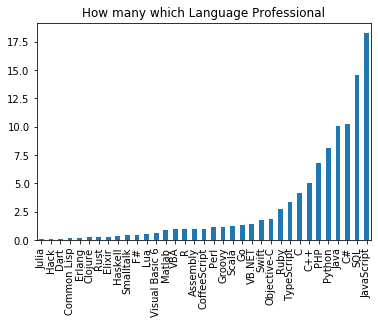

In [48]:
# step by step demo: 
# apply value_counts and sort by language name -- later on for join operation
prods = rds[rds.Professional == 'Professional developer']
layds = rds[rds.Professional != 'Professional developer']

md = rds['HaveWorkedLanguage'].value_counts().sort_index()/rds.shape[0]*100.
promd = prods['HaveWorkedLanguage'].value_counts().sort_index()/prods.shape[0]*100.
laymd = layds['HaveWorkedLanguage'].value_counts().sort_index()/layds.shape[0]*100.
print('lay ----\n', laymd.head(10), '----\n',  md.head(10), 'pro ----\n',  promd.head(10))

# apply value_counts and sort by value count  -- plot of preference
((rds['HaveWorkedLanguage'].value_counts()).sort_values()/rds.shape[0]*100.).plot(kind="bar");
plt.title("How many which Language");
plt.savefig("kindofcountlang.png")

# apply value_counts and sort by value count  -- plot of preference
((prods['HaveWorkedLanguage'].value_counts()).sort_values()/prods.shape[0]*100.).plot(kind="bar");
plt.title("How many which Language Professional");
plt.savefig("kindofcountlangpro.png")


Index(['Respondent', 'HaveWorkedLanguage', 'JobSatisfaction', 'Professional',
       'Weight', 'WantWorkLanguage'],
      dtype='object') 37499 33658 3841


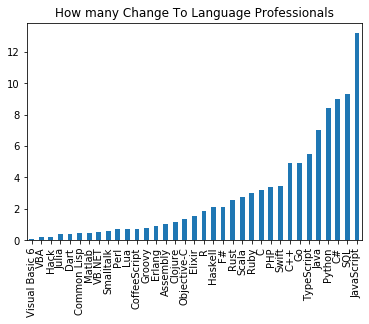

In [49]:
prosds = sds[sds.Professional == 'Professional developer']
laysds = sds[sds.Professional != 'Professional developer']
print(sds.columns,sds.shape[0],prosds.shape[0],laysds.shape[0])
print ('=============================')
# step by step demo: 
# apply value_counts and sort by language name -- later on for join operation
nd = sds['WantWorkLanguage'].value_counts().sort_index()/rds.shape[0]*100.
prond = prosds['WantWorkLanguage'].value_counts().sort_index()/prosds.shape[0]*100.
laynd = laysds['WantWorkLanguage'].value_counts().sort_index()/laysds.shape[0]*100.

# apply value_counts and sort by value count  -- plot of preference
((sds['WantWorkLanguage'].value_counts()).sort_values()/rds.shape[0]*100.).plot(kind="bar");
plt.title("How many Change To Language");
plt.savefig("kindofcountwishlang.png")

# apply value_counts and sort by value count  -- plot of preference
((prosds['WantWorkLanguage'].value_counts()).sort_values()/rds.shape[0]*100.).plot(kind="bar");
plt.title("How many Change To Language Professionals");
plt.savefig("kindofcountwishlangpro.png")

### Direct comparision: Join preference vectors, transpose and plot together

                HaveWorkedLanguage  WantWorkLanguage
Visual Basic 6            0.612056          0.097612
Hack                      0.071231          0.211054
VBA                       0.941828          0.226883
Dart                      0.089698          0.382535
Julia                     0.084422          0.406279
                HaveWorkedLanguage  WantWorkLanguage
Visual Basic 6            0.561401          0.083190
VBA                       0.752454          0.142611
Hack                      0.067603          0.196090
Julia                     0.064664          0.317904
Dart                      0.094057          0.392180
                HaveWorkedLanguage  WantWorkLanguage
Visual Basic 6            0.561401          0.083190
VBA                       0.752454          0.142611
Hack                      0.067603          0.196090
Julia                     0.064664          0.317904
Dart                      0.094057          0.392180


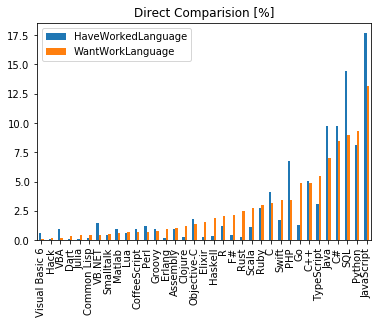

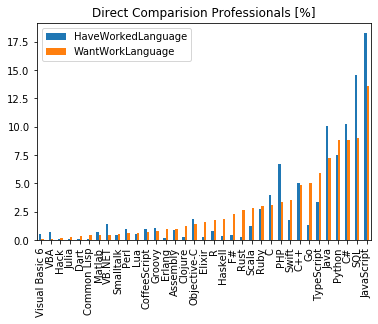

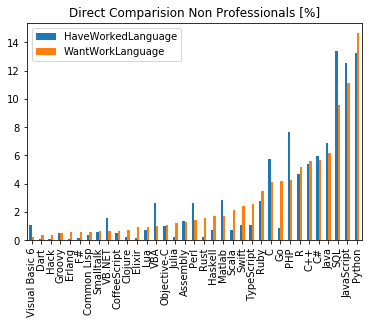

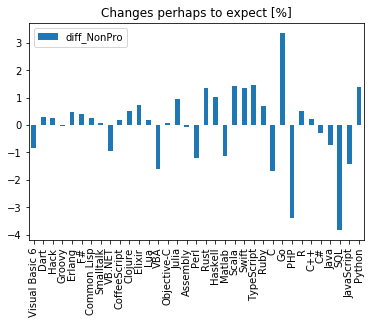

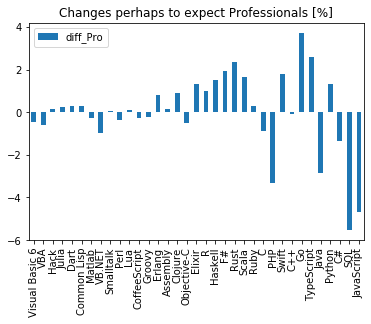

In [56]:
# due to sort_index, the indeizes of md and nd are the same and sorted together -- one common index in dataframe
# then, sort for values of one column to create base of preference plot, and plot the other values over
uf = pd.DataFrame([md,nd]).transpose().sort_values(['WantWorkLanguage'])
print(uf.head(5))
prouf = pd.DataFrame([promd,prond]).transpose().sort_values(['WantWorkLanguage'])
print(prouf.head(5))
layuf = pd.DataFrame([laymd,laynd]).transpose().sort_values(['WantWorkLanguage'])
print(prouf.head(5))

uf.plot(y=['HaveWorkedLanguage',  'WantWorkLanguage'], kind='bar')
plt.title("Direct Comparision [%]");
plt.savefig("kindofcomparision.png")

prouf.plot(y=['HaveWorkedLanguage',  'WantWorkLanguage'], kind='bar')
plt.title("Direct Comparision Professionals [%]");
plt.savefig("kindofcomparisionpro.png")

layuf.plot(y=['HaveWorkedLanguage',  'WantWorkLanguage'], kind='bar')
plt.title("Direct Comparision Non Professionals [%]");
plt.savefig("kindofcomparisionlay.png")

prouf['diff_Pro'] = prouf['WantWorkLanguage']-prouf['HaveWorkedLanguage']
layuf['diff_NonPro'] = layuf['WantWorkLanguage']-layuf['HaveWorkedLanguage']


layuf.plot(y=['diff_NonPro'], kind='bar')
plt.title("Changes perhaps to expect [%]");
plt.savefig("kindofchangeslay.png")

prouf.plot(y=['diff_Pro'], kind='bar')
plt.title("Changes perhaps to expect Professionals [%]");
plt.savefig("kindofchangespro.png")

plt